# In this notebook we will use the data to prepare a machine learning model to predict interest rate for a certain loan 

# We will only take loans where:
1. Income is verified 
2. Term is 36 months
3. The loan was fully funded
4. The loan was fully paid
5. The application type was individual (not joint)

### Explanation for these choices is given below

### Imports

In [4]:
import pandas as pd
# To read csv
import matplotlib.pyplot as plt
# For plotting
import seaborn as sns
# Plotting helper library
import numpy as np
# For mathematical functions
%matplotlib inline
# To allow plotting inside the notebook
import warnings
warnings.filterwarnings("ignore")
# To ignore deprecation warnings

### Reading the file

In [5]:
df=pd.read_csv("loan.csv", low_memory=False)
# Reading the data, low_memory=False as the file is very large
print(df.shape)
df.head()
# Shows the first 5 rows of the data

(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Start

In [6]:
dfnew = df[df['term']==" 36 months"]
# Creating a new data frame that we will be working with.
# Only taking rows where term is 36 months, for our initial analysis
dfnew.shape

(621125, 74)

In [7]:
dfnew=dfnew[dfnew['verification_status']!="Not Verified"]
# Taking into account that all accounts have income statuses verified
dfnew.shape

(398278, 74)

In [8]:
dfnew=dfnew[dfnew['loan_amnt']==dfnew['funded_amnt']]
# Only the loans which were fully funded
dfnew.shape

(397814, 74)

In [9]:
dfnew=dfnew[dfnew['loan_status']=="Fully Paid"]
# Only those that were fully paid back (no bad loans)
dfnew.shape

(97558, 74)

In [10]:
dfnew=dfnew[dfnew['application_type']=="INDIVIDUAL"]
# Taking only individual accounts into consideration
# Because there are very few joint accounts in the data, insufficient for prediction
dfnew.shape

(97557, 74)

In [11]:
corr = dfnew.corr()
# Finding correlation of remaining columns
corr.shape

(51, 51)

### Correlation matrix
#### Refer the included feature selection document for more details

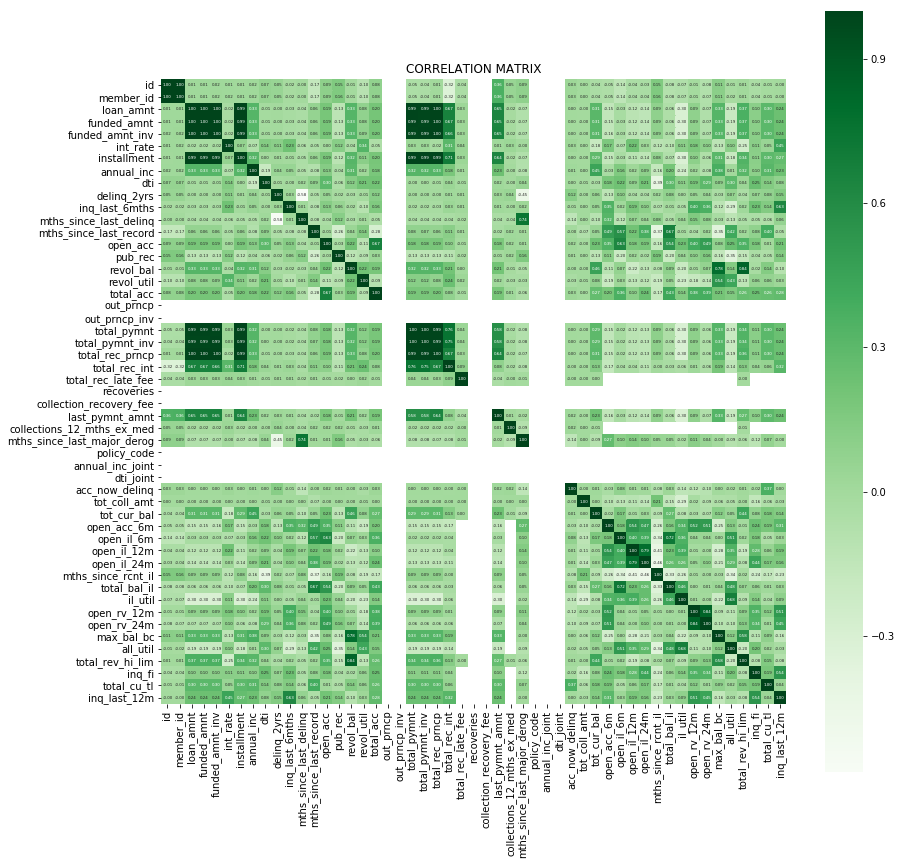

In [12]:
# Plotting a correlation matrix
plt.figure(figsize=(14,14))
plt.title("CORRELATION MATRIX")
sns.heatmap(corr, cbar=True, square= True, fmt='.2f',annot=True,annot_kws={'size':4}, cmap='Greens')

In [13]:
# Taking only the important columns from the large dataset
# (After finding important features from above data analysis and correlation matrix)
dfnew=dfnew[['loan_amnt','int_rate','home_ownership',
             'annual_inc','issue_d','purpose','addr_state','dti','sub_grade']]
dfnew.shape

(97557, 9)

In [14]:
dfnew.head()

,loan_amnt,int_rate,home_ownership,annual_inc,issue_d,purpose,addr_state,dti,sub_grade
0,5000.0,10.65,RENT,24000.0,Dec-2011,credit_card,AZ,27.65,B2
3,10000.0,13.49,RENT,49200.0,Dec-2011,other,CA,20.00,C1
5,5000.0,7.90,RENT,36000.0,Dec-2011,wedding,AZ,11.20,A4
7,3000.0,18.64,RENT,48000.0,Dec-2011,car,CA,5.35,E1
11,12000.0,12.69,OWN,75000.0,Dec-2011,debt_consolidation,CA,10.78,B5


In [15]:
# Month is unneccesary data, so creating a new column to store year
years = pd.to_datetime(dfnew.issue_d)
dfnew["year"] = years.dt.year
dfnew.drop(['issue_d'], inplace=True, axis=1)

In [16]:
# Renaming sub_grade column to grade
dfnew = dfnew.rename(columns={"sub_grade":"grade"})
dfnew.head()

,loan_amnt,int_rate,home_ownership,annual_inc,purpose,addr_state,dti,grade,year
0,5000.0,10.65,RENT,24000.0,credit_card,AZ,27.65,B2,2011
3,10000.0,13.49,RENT,49200.0,other,CA,20.00,C1,2011
5,5000.0,7.90,RENT,36000.0,wedding,AZ,11.20,A4,2011
7,3000.0,18.64,RENT,48000.0,car,CA,5.35,E1,2011
11,12000.0,12.69,OWN,75000.0,debt_consolidation,CA,10.78,B5,2011


### Using label encoder to convert string values to numerical
#### Since the machine learning model can only take numerical values into account

In [17]:
from sklearn.preprocessing import LabelEncoder

home_le = LabelEncoder()
dfnew['home_ownership'] = home_le.fit_transform(dfnew['home_ownership'])

purp_le = LabelEncoder()
dfnew['purpose'] = purp_le.fit_transform(dfnew['purpose'])

state_le = LabelEncoder()
dfnew['addr_state'] = state_le.fit_transform(dfnew['addr_state'])

grade_le = LabelEncoder()
dfnew['grade'] = grade_le.fit_transform(dfnew['grade'])

dfnew.head()

,loan_amnt,int_rate,home_ownership,annual_inc,purpose,addr_state,dti,grade,year
0,5000.0,10.65,5,24000.0,1,3,27.65,6,2011
3,10000.0,13.49,5,49200.0,9,4,20.00,10,2011
5,5000.0,7.90,5,36000.0,13,3,11.20,3,2011
7,3000.0,18.64,5,48000.0,0,4,5.35,20,2011
11,12000.0,12.69,4,75000.0,2,4,10.78,9,2011


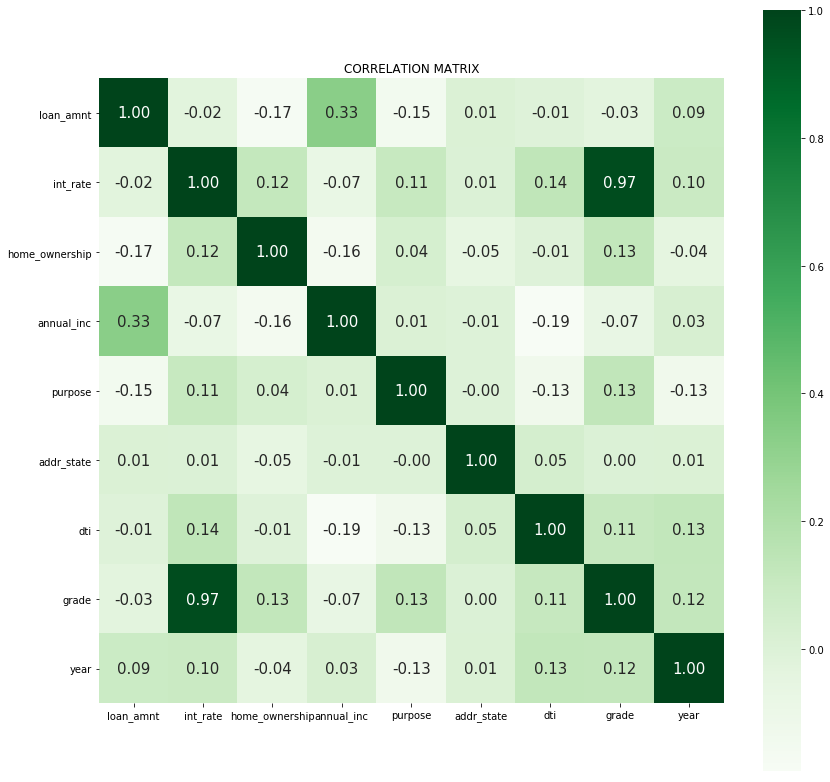

In [18]:
# Creating the correlation matrix for this data
corr = dfnew.corr()
corr.shape
plt.figure(figsize=(14,14))
plt.title("CORRELATION MATRIX")
sns.heatmap(corr, cbar=True, square= True, fmt='.2f',annot=True,annot_kws={'size':15}, cmap='Greens')
# We can see that interest rate depends highly upon grade

## Machine Learning

### Splitting the data into training and testing sets
### (70, 30) ratio as it is generally a good fit

In [31]:
from sklearn.model_selection import train_test_split

X=dfnew[['loan_amnt','grade','home_ownership','annual_inc','purpose','addr_state','dti','year']].values
y=dfnew['int_rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Using Gradient Boosting Regressor due to its robustness and general use. It works better than Random Forest because it fits more closely to the given data

#### For more details about gradient boosting: 
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
##### https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Fitting 
Number of inputs:  68289
Mean absolute error is: 
0.2827928112614459


Without outliers, mean absolute error is:  0.2811553839319276
Error distribution plot:



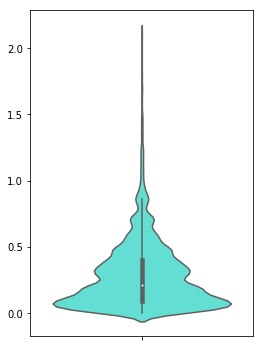

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

algo = GradientBoostingRegressor(n_estimators=110)
print("Fitting ")
print "Number of inputs: ",len(y_train)
model = algo.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred=np.round(y_pred,2)
print "Mean absolute error is: "
print(metrics.mean_absolute_error(y_test, y_pred))
print
errors = []
for i,j in zip(y_test, y_pred):
    if abs(i-j)<3:
        errors.append(abs(i-j))
print
print "Without outliers, mean absolute error is: ", np.mean(errors)
# There were some outliers where prediction was completely wrong
# only a few of these anomalies
plt.figure(figsize=(4,6))
print "Error distribution plot:"
sns.violinplot(y=errors, color="#4ff2e2")
print

## Hence we can see that upon training a Gradient Boosting Regression algorithm on the data, we are getting a mean absolute error of 0.281

In [33]:
print "Mean interest rate for the data is: "
print dfnew.int_rate.mean()

Mean interest rate for the data is: 
12.7379133225


In [34]:
print 1-np.mean(errors)/ dfnew.int_rate.mean()

0.9779276733312355


## Our model is accurate to within 97.79% of most of the values

#### How to generate label encoding dictionary

In [35]:
# Once a label encoder has been created and fit_transformed onto a column
# we can create a dictionary showing the mapping of the numerical and string values
# Say the label encoder was named home_le and it was fitted on the column home_ownership

# home_le = LabelEncoder()
# df['home_ownership'] = home_le.fit_transform(df['home_ownership'])

# Generating a mapping dictionary
le_name_mapping = dict(zip(home_le.classes_, home_le.transform(home_le.classes_)))
print "Home LE: ",le_name_mapping

Home LE:  {'NONE': 2, 'OWN': 4, 'MORTGAGE': 1, 'OTHER': 3, 'RENT': 5, 'ANY': 0}


#### This above method can be applied to any column with non-numerical values to generate the mapping dictionary
#### This dictionary is being used to encode the user's non-numerical inputs (ref. predict.py)